In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
# Tamaño del subconjunto de documentos con el que se va a trabajar.
# Se tomarán num_docs para training/validadación y num_docs para test.
num_docs = 20000
num_docs_test = 10000


# CARGAR DATOS

**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con depresión o es de control.


**control**:     0

**depresión**:   1

**ansiedad** :  2


In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /Data: A D C/train.csv'
data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
#data_train = data.iloc[:num_docs, :]
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97543 entries, 0 to 97542
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     65054 non-null  object 
 1   TWEET_ID    64990 non-null  float64
 2   TWEET_TEXT  97479 non-null  object 
 3   trastorno   97543 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.0+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,RT @FraRocanroleras: Te estás destruyendo y lo...,1
1,6,2.147484e+09,No sé cómo estar sin ti pero tampoco sé cómo e...,0
2,NaN,NaN,Me pregunto por qué últimamente no me siento ...,2
3,NaN,NaN,Mi ansiedad en torno a toda esta enfermedad s...,2
4,NaN,NaN,Esto ha estado en mi mente bastante durante lo...,2
5,NaN,NaN,¿Necesitas algunas ideas? Este canal es maravi...,2
6,31,2.147484e+09,"Intenté decir algo pero no pude,sólo quedé con...",0
7,27,2.147484e+09,tumblrbot ha preguntado: ROBOTS OR DINOSAURS? ...,1
8,49,2.147484e+09,El smirnoff es la bebida mas traicionera que e...,1
9,36,2.147484e+09,¿Por qué mis primas son delgadas y tan hermosa...,0


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'TWEET_TEXT'
null_values = data_train['TWEET_TEXT'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'TWEET_TEXT':", null_values)

Número de filas nulas o vacías en la columna 'TWEET_TEXT': 64


In [ ]:
data_train.dropna(subset=['TWEET_TEXT'], inplace=True)

# Verificar si hay filas nulas o vacías en la columna 'TWEET_TEXT'
null_values = data_train['TWEET_TEXT'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'TWEET_TEXT':", null_values)
data_train.info()

Número de filas nulas o vacías en la columna 'TWEET_TEXT': 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 97479 entries, 0 to 97542
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     64990 non-null  object 
 1   TWEET_ID    64990 non-null  float64
 2   TWEET_TEXT  97479 non-null  object 
 3   trastorno   97479 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


**DATOS DE PRUEBA**

In [ ]:
ruta_archivo_prueba = '/content/drive/MyDrive/Experimentación Python Tesis /Data: A D C/test.csv'
data_test = pd.read_csv(ruta_archivo_prueba, lineterminator='\n')
#data_test =data_t.iloc[:num_docs_test, :]
data_test.info()
data_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41805 entries, 0 to 41804
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     27874 non-null  object 
 1   TWEET_ID    27850 non-null  float64
 2   TWEET_TEXT  41781 non-null  object 
 3   trastorno   41805 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.3+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,17,2.147484e+09,RT @_badcatt: Necesito una electiva que me ens...,0
1,32,2.147484e+09,Mañana empiezo mi primera clase de danza y no ...,0
2,69,2.147484e+09,RT @StxpidFat: Vivo ilusionandome con cosas qu...,0
3,48,2.147484e+09,me quda poc,1
4,NaN,NaN,"3600.0, eso es algo como investigar, eventualm...",2


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'trastorno'
null = data_test['trastorno'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'trastorno':", null)

Número de filas nulas o vacías en la columna 'trastorno': 0


# Preparación de los datos

*Eliminar etiquedas HTML*

In [ ]:
import re

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

In [ ]:
import nltk
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_en = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


*Limpiar texto*

In [ ]:
import re
import string

def clean(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)

        # Eliminar URLs o enlaces
        text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

        # Eliminar nombres de usuarios de Twitter
        text = re.sub(r'@\w+', '', text)

        # Eliminar Nombres propios
        text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

        # Eliminar todos los caracteres especiales
        text = re.sub(r'[^\w\s]+', '', text)

        # Eliminar prefijos y números
        text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

        # Eliminar palabras específicas
        specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                          'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                          'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                          'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                          'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                          'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                          'it','we','they','the','and','that','these','those','tweet','followed','follower']
        text = ' '.join([word for word in text.split() if word not in specific_words])

        # Eliminar emojis
        emojis = re.findall(r'[^\w\s,]', text)
        cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                     '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                     ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
        for emoji in cleaned_emojis:
            text = text.replace(emoji, '')

        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar signos de puntuación
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

        words = text.split() #divide el texto en palabras individuales, creando una lista de palabras.

      # Combinar las stopwords en  español
        all_stopwords = stopwords_en
      # Filtrar las stopwords del texto
        filtered_words = [word for word in words if word.lower() not in all_stopwords] #filtra las palabras vacías del texto que no están en la lista de palabras vacías

        # Unir las palabras filtradas en un solo texto
        filtered_text = ' '.join(filtered_words)

        # Devuelve el texto limpio
        return text
    else:
        return text  # Devolver el valor original si no es de tipo string



#Elaboración de la lista de palabras relevantes a partir de una bolsa de palabras del mismo conjunto de datos

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

# Inicializar stemmer de NLTK
stemmer = PorterStemmer()

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))
def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gato', 'saltar', 'valla']


# Preprocesamieto del conjunto de datos de entrenamiento

In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(removeHTML)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(clean)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(extractTerms)
data_train.head(10)

,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,"[destruir, único, hacer, reírte]",1
1,6,2.147484e+09,"[cómo, tampoco, cómo, tú]",0
2,NaN,NaN,"[pregunto, últimamente, sentir, tranquilo, pun...",2
3,NaN,NaN,"[ansiedad, torno, todo, enfermedad, disparado]",2
4,NaN,NaN,"[mente, bastante, último, mes, compañero, cuar...",2
5,NaN,NaN,"[idea, canal, maravilloso, aquí, historia, seg...",2
6,31,2.147484e+09,"[intentar, decir, pudesólo, quedé, nudo, garga...",0
7,27,2.147484e+09,"[tumblrbot, preguntado, robot, dinosaurs]",1
8,49,2.147484e+09,"[smirnoff, bebido, mas, traicionero, existir, ...",1
9,36,2.147484e+09,"[prima, delgado, tanto, hermosa, vida]",0


In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)


Número de elementos vacíos en la columna 'TWEET_TEXT': 5408


In [ ]:
# Filtrar filas donde 'TWEET_TEXT' no sea una lista vacía
data_train = data_train[data_train['TWEET_TEXT'].apply(len) > 0]

# Reiniciar el índice del DataFrame después de eliminar filas
data_train.reset_index(drop=True, inplace=True)

In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 0


In [ ]:

data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) # Combinar los elementos de la lista en una sola cadena separados por espacios
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92071 entries, 0 to 92070
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     59713 non-null  object 
 1   TWEET_ID    59713 non-null  float64
 2   TWEET_TEXT  92071 non-null  object 
 3   trastorno   92071 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 2.8+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,destruir único hacer reírte,1
1,6,2.147484e+09,cómo tampoco cómo tú,0
2,NaN,NaN,pregunto últimamente sentir tranquilo punto au...,2
3,NaN,NaN,ansiedad torno todo enfermedad disparado,2
4,NaN,NaN,mente bastante último mes compañero cuarto anc...,2
5,NaN,NaN,idea canal maravilloso aquí historia seguir vi...,2
6,31,2.147484e+09,intentar decir pudesólo quedé nudo gargantar l...,0
7,27,2.147484e+09,tumblrbot preguntado robot dinosaurs,1
8,49,2.147484e+09,smirnoff bebido mas traicionero existir chabon...,1
9,36,2.147484e+09,prima delgado tanto hermosa vida,0


# Representación de los datos mediante una matriz TF-IDF

se guardan los valores de la matriz TFIDF y los array X y para futuros entrenamientos

Se procederá a construir un conjunto de entrenamiento a partir de la representación de bolsa de palabras o inglés (Bag of Words.)

In [ ]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

def Tokenizer(text):
    return text.split()  # Tokenizador simple: divide el texto en palabras
# Crear un transformador CountVectorizer con el tokenizer Tokenizery rango de n-gramas (1, 1)
# y un umbral de frecuencia mínimo de 200
umbral = 20

# Crear un transformador TfidfVectorizer con el tokenizer extractTerms y rango de n-gramas (1, 1)
tfidf_vect  = TfidfVectorizer(tokenizer=Tokenizer, ngram_range=(1, 1), min_df=umbral)
# Aplicar el TfidfVectorizer a la columna 'TWEET_TEXT' en data_train y obtener la matriz TF-IDF
tfidf_train  = tfidf_vect.fit_transform(data_train['TWEET_TEXT'].values)
# Imprimir el tamaño del vocabulario construido por TfidfVectorizer
print("El tamaño del vocabulario es: ", len(tfidf_vect.vocabulary_))

X = tfidf_train # Matriz TF-IDF
y = data_train['trastorno'].values # Etiquetas de trastorno de la columna 'trastorno'


El tamaño del vocabulario es:  3631


In [ ]:
print(X.shape)
print(y.shape)

(92071, 3631)
(92071,)


#Dividir la matriz BoW en 10 secciones de 9,207 mil
la matriz de divide en valores de X1 hasa X10 don sus estiquedas de y1 hasta y10, esto permite entrenar a la red neuronal con pequeños valores sin cambiar el numero de vacabulario total.

In [ ]:
# Se guardan los primeros 9207 datos de la matriz BoW con los respectivas etiquetas y en X1, y1 hasta X20,y20 así hasta
# completar los 245524 datos del dataset

# matrices bow_train
total_datos = tfidf_train.shape[0]  # Número total de filas en la matriz bow_train.
tamaño_conjunto = 9207 #  Tamaño deseado para cada conjunto

# etiquetas están en la variable 'y'
etiquetas = data_train['trastorno'].values

# Crea variables para guardar los conjuntos
conjuntos_X = []
conjuntos_y = []

# Divide tus datos en 20 conjuntos de 9207 filas cada uno
for i in range(10):
    inicio = i * tamaño_conjunto #calcula el índice de inicio del conjunto actual.
    fin = (i + 1) * tamaño_conjunto # índice de finalización del conjunto actual i + 1 representa la siguiente iteración del bucle, por lo que se multiplica por tamaño_conjunto para obtener la fila de finalización.
    #Generan nombres de variables dinámicos para los conjuntos de datos y etiquetas de cada conjunto.
    X_nombre = f'X{i+1}'
    y_nombre = f'y{i+1}'
    conjunto_X = tfidf_train[inicio:fin, :]  # selecciona las filas correspondientes a este conjunto desde la matriz bow_train. Utiliza la notación de corte (slicing) para seleccionar las filas desde inicio hasta fin.
    conjunto_y = etiquetas[inicio:fin]  # selecciona las etiquetas correspondientes a este conjunto. Estas etiquetas se toman de la variable etiquetas que contiene las etiquetas de sentimientos.
    #  Asignan los conjuntos de datos y etiquetas a variables con nombres dinámicos (X1, y1, X2, y2, etc.)
    globals()[X_nombre] = conjunto_X
    globals()[y_nombre] = conjunto_y
    # Agregan los conjuntos de datos y etiquetas a las listas, respectivamente, para mantener un registro de todos los conjuntos creados.
    conjuntos_X.append(conjunto_X)
    conjuntos_y.append(conjunto_y)

**genreal valores aleatorios de X, y para el entrenamiento de la red neuronal**

In [ ]:
import random

# Genera un número aleatorio entre 1 y 10
i = random.randint(1, 10)
# Crea las variables Xi y yi con los datos seleccionados aleatoriamente
Xi = globals()[f'X{i}']
yi = globals()[f'y{i}']
print(f'X{i}', Xi.shape)
print(f'y{i}', yi.shape)

X10 (9207, 3631)
y10 (9207,)


# Entrenamiento con validación 70 - 30

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

In [ ]:


# Convertir la matriz BoW a una matriz densa de Numpy
X = Xi.toarray()
y=yi
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
# Verificar las dimensiones de los conjuntos de entrenamiento y validación
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_val:", X_val.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_val:", y_val.shape)

Dimensiones de X_train: (6905, 3631)
Dimensiones de X_val: (2302, 3631)
Dimensiones de y_train: (6905,)
Dimensiones de y_val: (2302,)


# Aprendizaje del modelo: Red Neuronal simple

In [ ]:

from keras.utils import to_categorical
# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización
# Convertir las etiquetas en codificación one-hot
num_classes = 3  # Número de clases
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)

# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características en X_train
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con el número de clases en tu clasificación multiclase
model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=60, validation_data=(X_val, y_val_one_hot))

y_val_pred = model.predict(X_val)

y_val_pred_class = y_val_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_val_true_class = y_val_one_hot.argmax(axis=1)  # Usar y_val_one_hot en lugar de y_val si está codificado en one-hot

accuracy = accuracy_score(y_val_true_class, y_val_pred_class)
precision = precision_score(y_val_true_class, y_val_pred_class, average='macro')
recall = recall_score(y_val_true_class, y_val_pred_class, average='macro')
f1 = f1_score(y_val_true_class, y_val_pred_class, average='macro')

y_train_pred = model.predict(X_train)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred_class = y_train_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_train_true_class = y_train_one_hot.argmax(axis=1)  # Usar y_train_one_hot en lugar de y_train si está codificado en one-hot

accuracy_train = accuracy_score(y_train_true_class, y_train_pred_class)
precision_train = precision_score(y_train_true_class, y_train_pred_class, average='macro')
recall_train = recall_score(y_train_true_class, y_train_pred_class, average='macro')
f1_train = f1_score(y_train_true_class, y_train_pred_class, average='macro')

# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad Depresión/Modelos ya entrenadosmodelo_entrenado_multiclase.h5')

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad Depresión/Modelos ya entrenadosmodelo_entrenado_multiclase.h5')





In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 96.0%
Precisión (entrenamiento): 96.0%
Recall (entrenamiento): 96.0%
F1-score (entrenamiento): 96.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 59.0%
Precisión en el conjunto de validación: 57.99999999999999%
Recall en el conjunto de validación: 57.99999999999999%
F1-score en el conjunto de validación: 57.99999999999999%


#Matriz de confusión

entrenamiento

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_true_class, y_train_pred_class)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[2101  107    5]
 [ 130 2088    4]
 [   3   11 2456]]


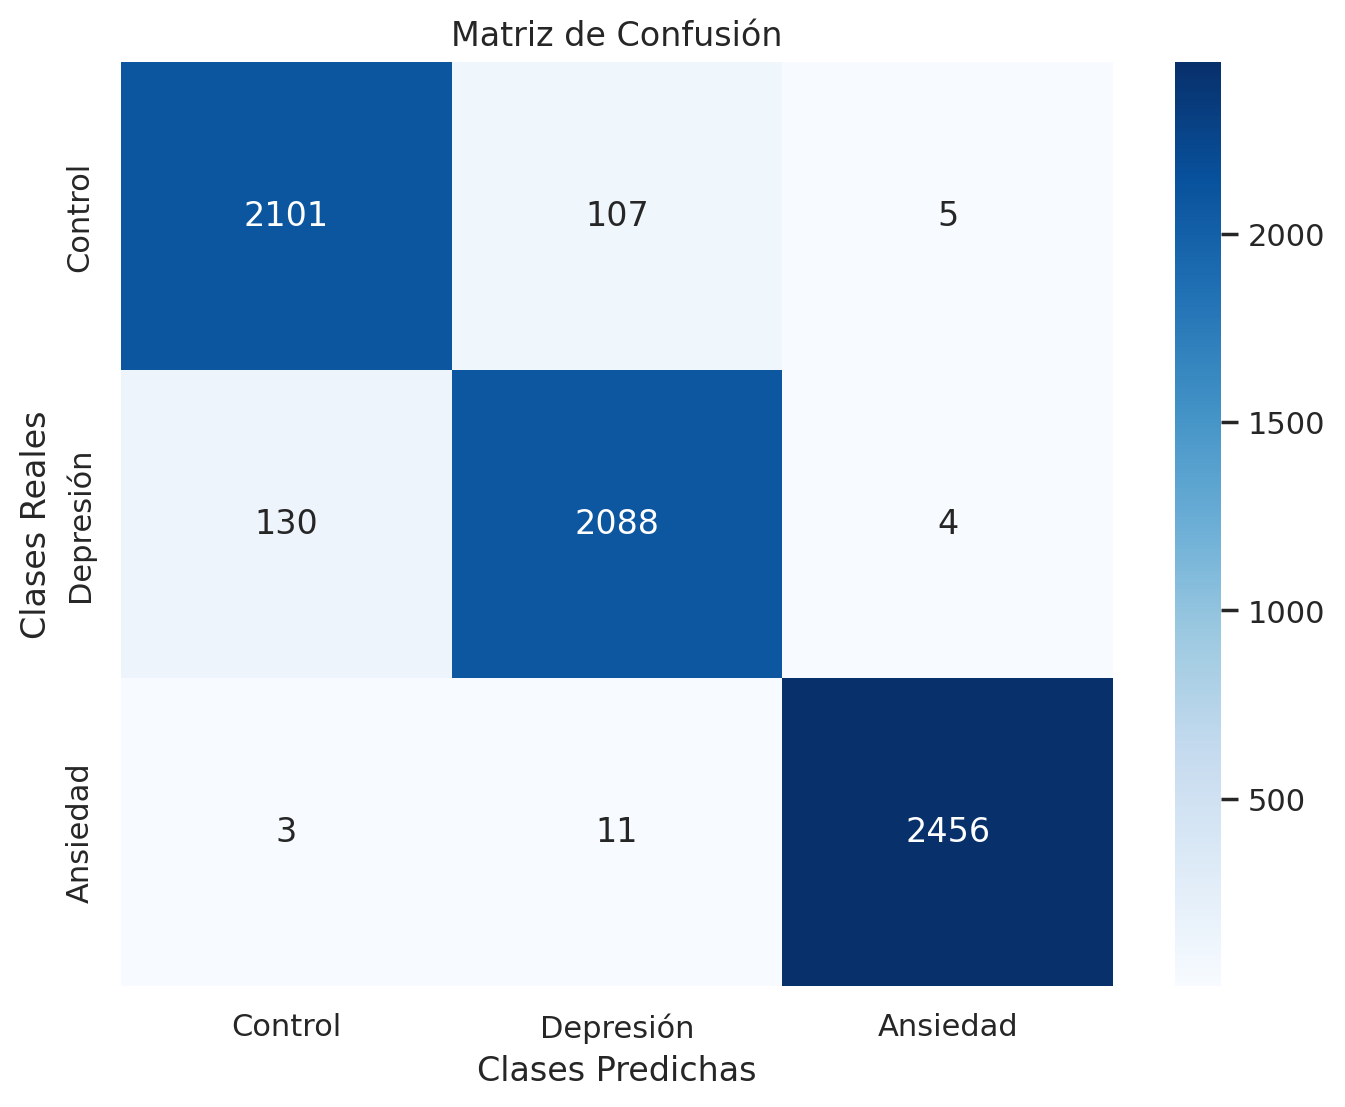

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

validación

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val_true_class, y_val_pred_class)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[312 376  54]
 [329 357  65]
 [ 43  78 688]]


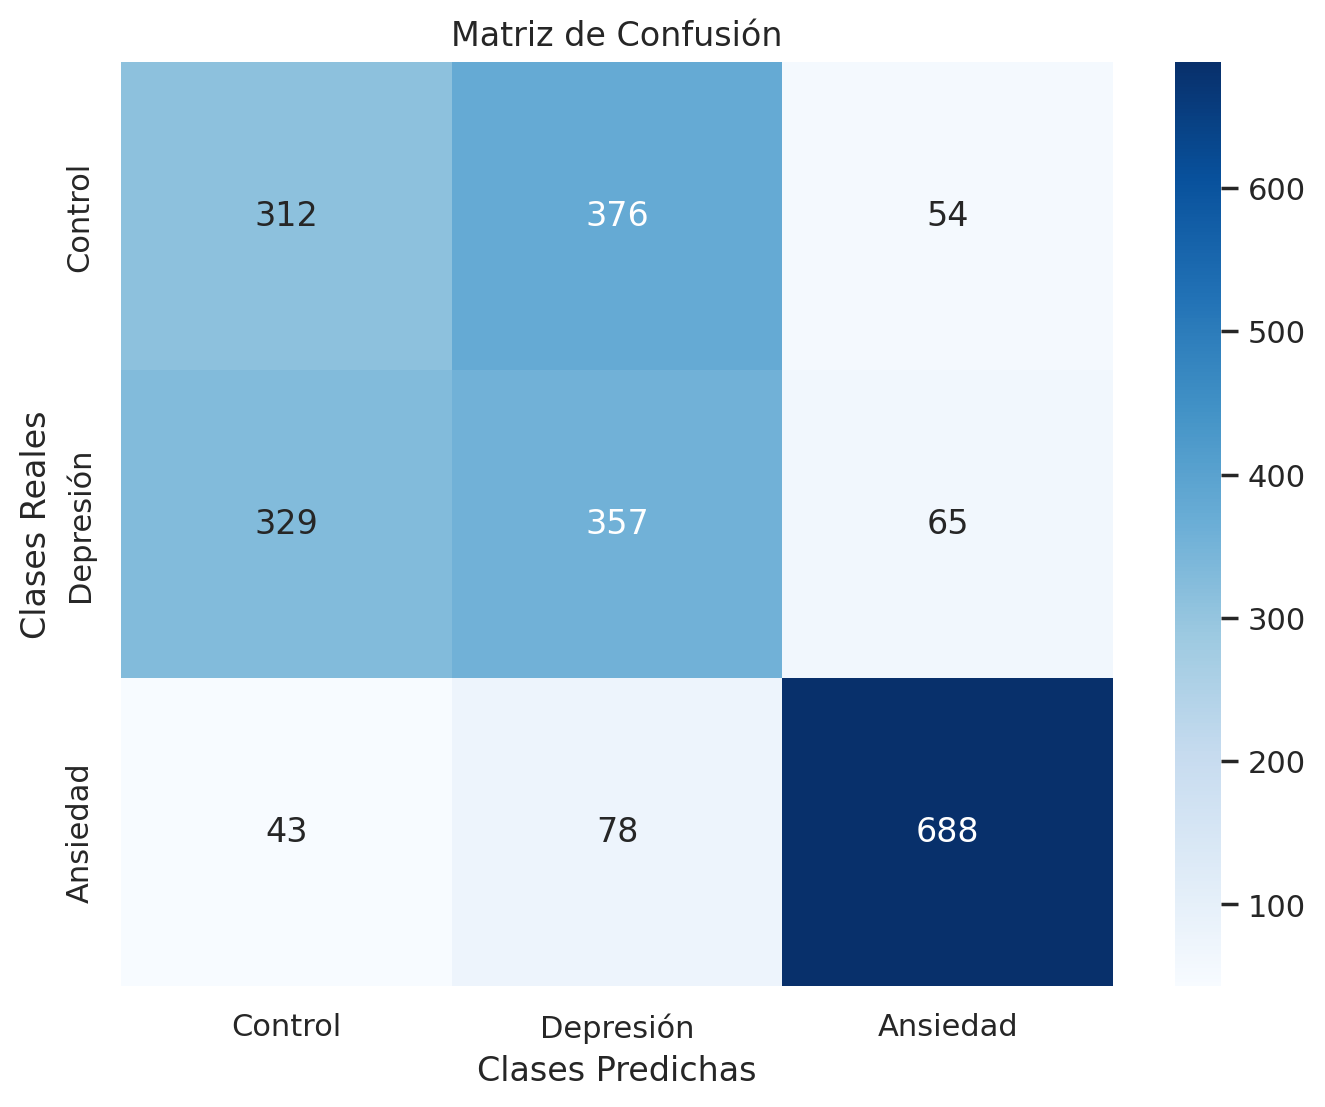

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

# Entrenamiento con validación cruzada k=10

In [ ]:
# Convertir las etiquetas en codificación one-hot
num_classes = 3  # Número de clases
y_one_hot = to_categorical(y, num_classes)

# Crear listas para almacenar las métricas de entrenamiento y validación
train_accuracy_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []
val_accuracy_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []

# Realizar validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)  # Puedes ajustar el número de divisiones según sea necesario

for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train_one_hot, y_val_one_hot = y_one_hot[train_index], y_one_hot[val_index]

    # Crear una red neuronal secuencial
    model = Sequential()
    model.add(Dense(328, activation='relu', input_dim=X.shape[1]))
    model.add(Dropout(0.1))
    model.add(Dense(164, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

    # Entrenar el modelo en los datos de entrenamiento
    model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32)

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    y_train_pred_class = y_train_pred.argmax(axis=1)
    y_train_true_class = y_train_one_hot.argmax(axis=1)

    train_accuracy = accuracy_score(y_train_true_class, y_train_pred_class)
    train_precision = precision_score(y_train_true_class, y_train_pred_class, average='macro')
    train_recall = recall_score(y_train_true_class, y_train_pred_class, average='macro')
    train_f1 = f1_score(y_train_true_class, y_train_pred_class, average='macro')

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = model.predict(X_val)
    y_val_pred_class = y_val_pred.argmax(axis=1)
    y_val_true_class = y_val_one_hot.argmax(axis=1)

    val_accuracy = accuracy_score(y_val_true_class, y_val_pred_class)
    val_precision = precision_score(y_val_true_class, y_val_pred_class, average='macro')
    val_recall = recall_score(y_val_true_class, y_val_pred_class, average='macro')
    val_f1 = f1_score(y_val_true_class, y_val_pred_class, average='macro')

    # Almacenar las métricas en las listas
    train_accuracy_list.append(train_accuracy)
    train_precision_list.append(train_precision)
    train_recall_list.append(train_recall)
    train_f1_list.append(train_f1)
    val_accuracy_list.append(val_accuracy)
    val_precision_list.append(val_precision)
    val_recall_list.append(val_recall)
    val_f1_list.append(val_f1)

# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad Depresión/Modelos ya entrenadosmodelo_entrenado_multiclase(k=10).h5')

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad Depresión/Modelos ya entrenadosmodelo_entrenado_multiclase(k=10).h5')




Epoch 1/10
231/231 [==============================] - 2s 4ms/step - loss: 0.7779 - categorical_accuracy: 0.5701
Epoch 2/10
231/231 [==============================] - 1s 4ms/step - loss: 0.5580 - categorical_accuracy: 0.6987
Epoch 3/10
231/231 [==============================] - 1s 4ms/step - loss: 0.4372 - categorical_accuracy: 0.7852
Epoch 4/10
231/231 [==============================] - 1s 4ms/step - loss: 0.3296 - categorical_accuracy: 0.8455
Epoch 5/10
231/231 [==============================] - 1s 4ms/step - loss: 0.2364 - categorical_accuracy: 0.8941
Epoch 6/10
231/231 [==============================] - 1s 4ms/step - loss: 0.1756 - categorical_accuracy: 0.9237
Epoch 7/10
231/231 [==============================] - 1s 4ms/step - loss: 0.1446 - categorical_accuracy: 0.9409
Epoch 8/10
231/231 [==============================] - 1s 4ms/step - loss: 0.1293 - categorical_accuracy: 0.9442
Epoch 9/10
231/231 [==============================] - 1s 4ms/step - loss: 0.1154 - categorical_accuracy:

In [ ]:
# Imprimir
print("Métricas de entrenamiento - Accuracy:", np.mean(train_accuracy_list)*100)
print("Métricas de entrenamiento - Precision:", np.mean(train_precision_list)*100)
print("Métricas de entrenamiento - Recall:", np.mean(train_recall_list)*100)
print("Métricas de entrenamiento - F1-score:", np.mean(train_f1_list)*100)
print('--'*100)
print("Métricas de validación - Accuracy:", np.mean(val_accuracy_list)*100)
print("Métricas de validación - Precision:", np.mean(val_precision_list)*100)
print("Métricas de validación - Recall:", np.mean(val_recall_list)*100)
print("Métricas de validación - F1-score:", np.mean(val_f1_list)*100)

Métricas de entrenamiento - Accuracy: 95.95144716398477
Métricas de entrenamiento - Precision: 95.85881905719758
Métricas de entrenamiento - Recall: 95.82265097701284
Métricas de entrenamiento - F1-score: 95.8240735446198
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Métricas de validación - Accuracy: 59.56311804765504
Métricas de validación - Precision: 58.03464644102427
Métricas de validación - Recall: 58.51604738717431
Métricas de validación - F1-score: 58.185745619787824


#Matriz de confusión

entrenamiento

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_true_class, y_train_pred_class)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[2199  161    4]
 [ 119 2257    3]
 [   4   11 2608]]


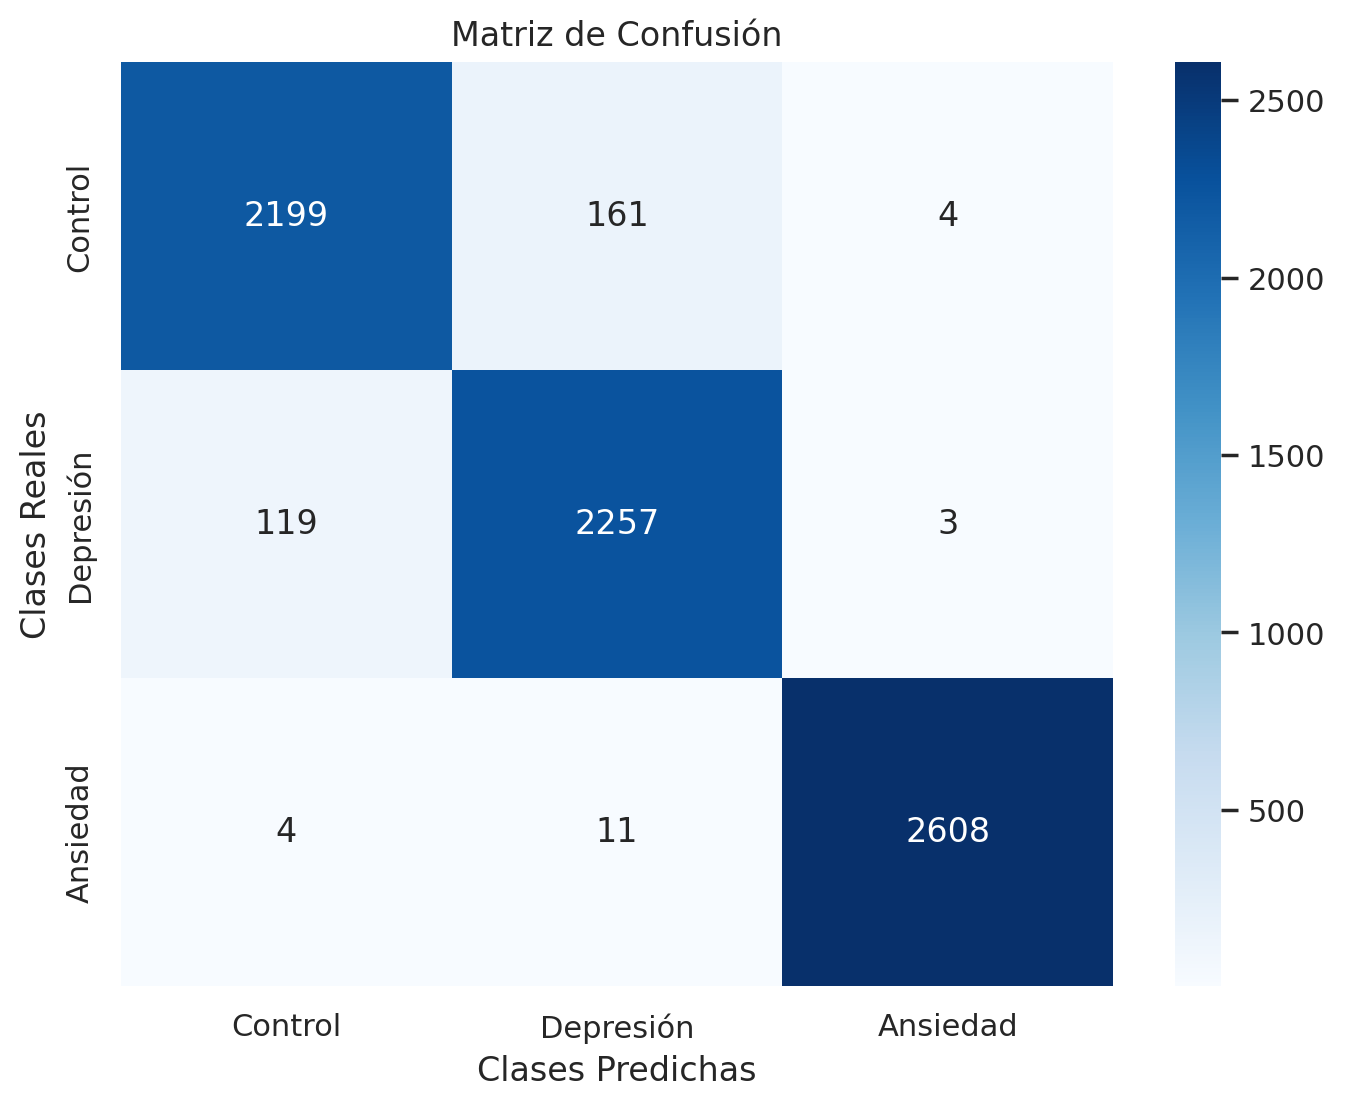

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

validación

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val_true_class, y_val_pred_class)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[262 271  58]
 [293 250  51]
 [ 39  37 580]]


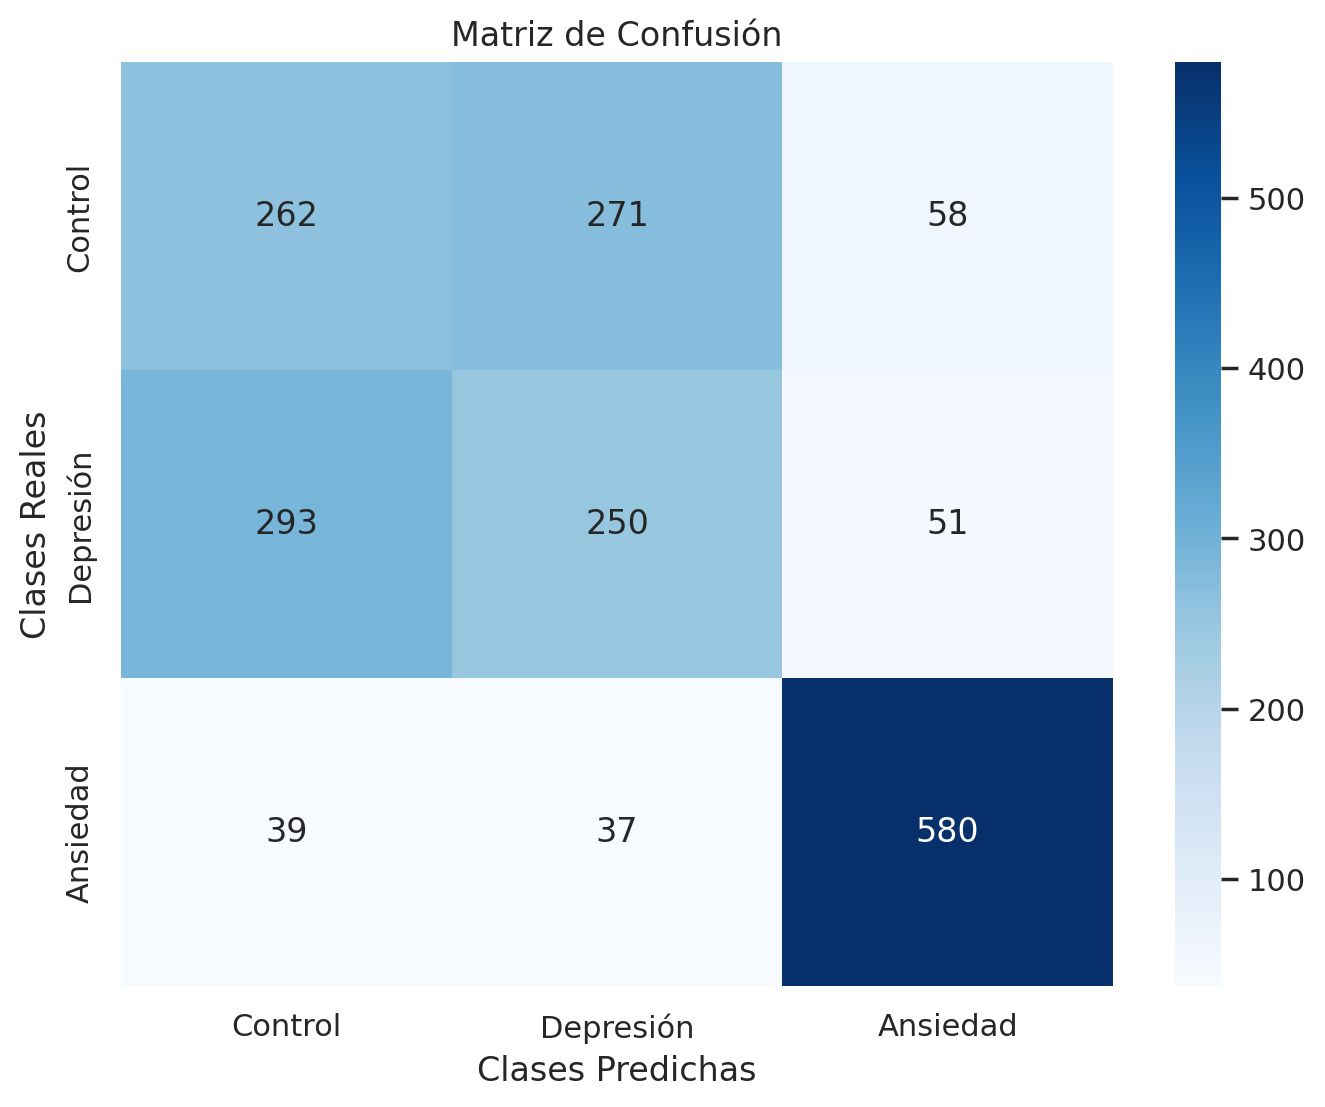

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

Guardar el modelo

In [ ]:
import joblib
import os
# Directorio para guardar modelos entrenados
model_dir = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad Depresión/BOW/parametros de los modelos'
model_filename = 'TWEETS_depresivos-ansiedad (BoW) (RN-CV=10).pkl'
model_path_p = os.path.join(model_dir, model_filename)

# Guardar el modelo entrenado
joblib.dump(model, model_path_p)

['/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad Depresión/BOW/parametros de los modelos/TWEETS_depresivos-ansiedad (BoW) (RN-CV=10).pkl']